# A Network Tour of Data Science, EPFL 2016
# Project: Facial Emotion Recognition
Dataset taken from: kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge
<br>
<br>
students: Patryk Oleniuk, Carmen Galotta



The project presented here is an algorithm to recognize and detect emotions from a face picture. 

Of course, the task of recognize face emotions is very easy for humans to do even if somethimes is really hard to understand how a person feels, but what can be easily understood thanks to human's brain, is difficult to emulate by a machine.

The aim of this project is to classify faces in discrete human emotions. Due to the success of Neural Network in images classification tasks it has been tought that employing it could  be a good idea in also face emotion.

The dataset has been taken from the kaggle competition and consists of 48x48 grey images already labeled with a number coding for classes of emotions, namely: 

0-Angry<br>
1-Disgust<br>
2-Fear<br>
3-Happy<br>
4-Sad<br>
5-Surprise<br>
6-Neutral<br>

The faces are mostly centered in the image.

# Configuration, dataset file

In [155]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import scipy.misc
import time
import collections
import os
import utils as ut
import importlib
import copy

importlib.reload(ut)

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 20.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

#Data Visualization
# Load the shortened raw CSV data, it contains only 300 pictures with labels
emotions_dataset_dir = 'fer2013_full.csv'

#obtaining the number of line of the csv file
file = open(emotions_dataset_dir)
numline = len(file.readlines())
print ('Number of data in the dataset:',numline)


Number of data: 35887


# Load the data from *.csv file 
The first step is to load the data from the .csv file. <br> The  format of the csv line is<br>
class{0,1,2,3,4,5,6},pix0 pix2304,DataUsage(not used)<br>
e.g.<br>
2,234 1 34 23 ..... 234 256 0,Training<br>
The picture is always 48x48 pixels, 0-255 greyscale.
# Remove strange data
In the database there are some images thar are not good (e.g. some images are pixelated, unrelevant, from animations).
It has been tried to filter them by looking at the maximum of the histogram. If the image is very homogenous, the maximum value of the histogram will be very high (that is to say above a certain threshold) then this image is filtered out. Of course in this way are also removed some relevant information, but it's better for the CNN not to consider these images.
# Merge class 0 and 1
We discovered that class 1 has a very small amount of occurance in the test data et. This class, (disgust) is very similar to anger and that is why we merger class 0 and 1 together.
Therefore, the recognized emotions and labels are
0-Angry + Disgust
1-Fear
2-Happy
3-Sad
4-Surprise
5-Neutral

In [157]:
#Load the file in csv
ifile  = open(emotions_dataset_dir, "rt")
reader = csv.reader(ifile)

#preparing labels(Y) and images(X) data vectors
rownum = 0
num_data = numline;

#preparing arrays
emotions = np.zeros(num_data)
images = np.zeros((num_data,48,48))
strange_im = np.zeros((int(num_data/10),48,48)) # the dataset contains <10% of strange img

# for image pre-filtering
num_strange = 0; #number of removed images
num_skipped = 0; #hapy images skip counter
hist_threshold = 350 # images above this threshold will be removed
hist_div = 100 #parameter of the histogram

#parsing each row
for row in reader:
    #(column0) extract the emotion label
    #!!!! convert 1 and 0 together !!!!
    if( (row[0] == '0') or (row[0] == '1' ) ):
        emotions[rownum] = '0';
    else :
        emotions[rownum] = str(int(row[0])-1)
        
    #ignore 1/3 of happy cklass pic, there are too many in relative to to others  
    if( (emotions[rownum] != 2 ) or ((emotions[rownum] == 2) and (np.random.choice([0,1,1]) == 1) )): 

        #(column1) extract the image data, parse it and convert into 48x48 array of integers
        images[rownum] = np.asarray([int(s) for s in row[1].split(' ')]).reshape(48,48)

        #stretching contrast of the image
        images[rownum] = ut.contrast_stretch(images[rownum])

        #calculating the histogram and erasing "strange" images
        y_h, x_h = np.histogram( images[ rownum ] , 100 );
        if y_h.max() > hist_threshold  : 
            # if img is 'strange'
            strange_im[num_strange,:,:] = images[rownum,:,:];
            num_data = num_data - 1;
            images = np.delete(images, rownum, axis = 0);
            emotions = np.delete(emotions, rownum)
            #print('deleted:',rownum, y_h.max())
            num_strange += 1;   
        else:
            rownum += 1
        if not rownum%500:
            print("loaded %2.0f" % ((float(rownum ) /num_data)*100) 
                  + '% of dataset ('+ str(rownum+num_strange)+'/'+ str(numline) + '). Filtered images: ' + str(num_strange) )
    else:
        images = np.delete(images, rownum, axis = 0);
        emotions = np.delete(emotions, rownum)
        num_skipped +=1; # skip some happy images 
        
ifile.close()
print('skipped ',num_skipped,' happy images.');
print(str( len(images) ) + ' are left after \'strange images\' removal.')
print('Deleted ' + str( num_strange ) + ' strange images. Images are shown below')

loaded  1% of dataset (531/35887). Filtered images: 31
loaded  3% of dataset (1052/35887). Filtered images: 52
loaded  4% of dataset (1569/35887). Filtered images: 69
loaded  6% of dataset (2095/35887). Filtered images: 95
loaded  7% of dataset (2624/35887). Filtered images: 124
loaded  8% of dataset (3153/35887). Filtered images: 153
loaded  8% of dataset (3154/35887). Filtered images: 154
loaded 10% of dataset (3672/35887). Filtered images: 172
loaded 11% of dataset (4189/35887). Filtered images: 189
loaded 13% of dataset (4721/35887). Filtered images: 221
loaded 14% of dataset (5251/35887). Filtered images: 251
loaded 15% of dataset (5783/35887). Filtered images: 283
loaded 17% of dataset (6316/35887). Filtered images: 316
loaded 18% of dataset (6835/35887). Filtered images: 335
loaded 20% of dataset (7371/35887). Filtered images: 371
loaded 21% of dataset (7898/35887). Filtered images: 398
loaded 21% of dataset (7899/35887). Filtered images: 399
loaded 21% of dataset (7900/35887). 

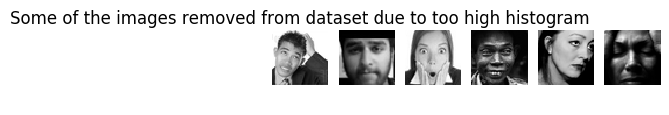

In [163]:
# showing strange images
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
idxs = np.random.choice(range(1,num_strange ), 6, replace=False)
for i, idx in enumerate(idxs):
    plt_idx = i
    plt.subplot(1, 6, plt_idx+1)
    plt.imshow(strange_im[idx])
    plt.axis('off')
    if(i == 0):
        plt.title('Some of the images removed from dataset due to too high histogram')
plt.show()

# Explore the data
Plot some random pictures from each class.

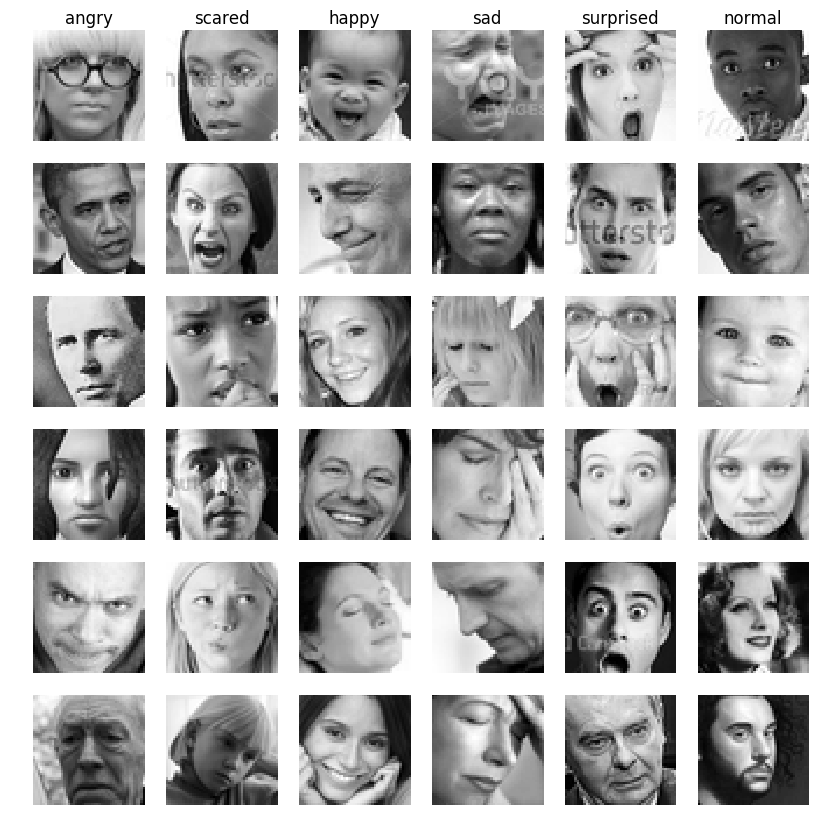

In [164]:
classes = [0,1,2,3,4,5]
str_emotions = ['angry','scared','happy','sad','surprised','normal']
num_classes = len(classes)
samples_per_class = 6
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(emotions == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(images[idx])
        y_h, x_h = np.histogram( images[idx], hist_div );
        plt.axis('off')
        if(i == 0):
            plt.title(str_emotions[y] )
plt.show()

# Prepare the Data for CNN
Here the initial data have been divided to create train and test data. <bv>
This two subsets have both an associated label to train the neural network and to test its accuracy with the test data.
The number of images used for each category of emotions is shown both for the train as for the test data.

In [165]:
print('number of clean data:' + str(images.shape[0]) + '  48x48 pix , 0-255 greyscale images')
n_all = images.shape[0];
n_train = 64; # number of data for training and for batch

# dividing the input data
train_data_orig = images[0:n_all-n_train,:,:]
train_labels = emotions[0:n_all-n_train]
test_data_orig = images[n_all-n_train:n_all,:,:]
test_labels = emotions[n_all-n_train:n_all]

# Convert to float
train_data_orig = train_data_orig.astype('float32')
y_train = train_labels.astype('float32')
test_data_orig = test_data_orig.astype('float32')
y_test = test_labels.astype('float32')

print('orig train data ' + str(train_data_orig.shape))
print('orig train labels ' + str(train_labels.shape) + 'from ' + str(train_labels.min()) + ' to ' + str(train_labels.max()) )
print('orig test data ' + str(test_data_orig.shape))
print('orig test labels ' + str(test_labels.shape)+ 'from ' + str(test_labels.min()) + ' to ' + str(test_labels.max()) )

for i in range (0, 5):  
    print('TRAIN: number of' , i, 'labels',len(train_labels[train_labels == i]))

for i in range (0, 5):  
    print('TEST: number of', i, 'labels',len(test_labels[test_labels == i]))


number of clean data:31197  48x48 pix , 0-255 greyscale images
orig train data (31133, 48, 48)
orig train labels (31133,)from 0.0 to 5.0
orig test data (64, 48, 48)
orig test labels (64,)from 0.0 to 5.0
TRAIN: number of 0 labels 5134
TRAIN: number of 1 labels 4829
TRAIN: number of 2 labels 5789
TRAIN: number of 3 labels 5765
TRAIN: number of 4 labels 3740
TEST: number of 0 labels 13
TEST: number of 1 labels 12
TEST: number of 2 labels 11
TEST: number of 3 labels 7
TEST: number of 4 labels 12


# Prepare the data for CNN
Convert, normalize, subtract the const mean value from the data images.


In [ ]:
# Data pre-processing
n = train_data_orig.shape[0];
train_data = np.zeros([n,48**2])
for i in range(n):
    xx = train_data_orig[i,:,:]
    xx -= np.mean(xx)
    xx /= np.linalg.norm(xx)
    train_data[i,:] = xx.reshape(2304); #np.reshape(xx,[-1])

n = test_data_orig.shape[0]
test_data = np.zeros([n,48**2])
for i in range(n):
    xx = test_data_orig[i,:,:]
    xx -= np.mean(xx)
    xx /= np.linalg.norm(xx)
    test_data[i] = np.reshape(xx,[-1])

#print(train_data.shape)
#print(test_data.shape)
#print(train_data_orig[0][2][2])
#print(test_data[0][2])
plt.rcParams['figure.figsize'] = (2.0, 2.0) # set default size of plots
plt.imshow(train_data[4].reshape([48,48]));
plt.title('example image after processing');

In [167]:
# Convert label values to one_hot vector

train_labels = ut.convert_to_one_hot(train_labels,num_classes)
test_labels = ut.convert_to_one_hot(test_labels,num_classes)

print('train labels shape',train_labels.shape)
print('test labels shape',test_labels.shape)

train labels shape (31133, 6)
test labels shape (64, 6)


# Model 1

In the first model it has been implemented a baseline softmax classifier using a single convolutional layer and a one fully connected layer. For the initial baseline
it has not be used any regularization, dropout, or batch normalization.

The equation of the classifier is simply:


$$
y=\textrm{softmax}(ReLU( x \ast W_1+b_1)W_2+b_2) 
$$


In [ ]:
# Define computational graph (CG)
batch_size = n_train    # batch size
d = train_data.shape[1]  # data dimensionality
nc = 6                  # number of classes

# CG inputs
xin = tf.placeholder(tf.float32,[batch_size,d]); #print('xin=',xin,xin.get_shape())
y_label = tf.placeholder(tf.float32,[batch_size,nc]); #print('y_label=',y_label,y_label.get_shape())
#d = tf.placeholder(tf.float32);

# Convolutional layer
K0 = 10   # size of the patch
F0 = 64  # number of filters
ncl0 = K0*K0*F0
Wcl0 = tf.Variable(tf.truncated_normal([K0,K0,1,F0], stddev=tf.sqrt(2./tf.to_float(ncl0)) )); print('Wcl=',Wcl0.get_shape())
#bcl0 = tf.Variable(tf.zeros([F0])); print('bcl=',bcl0.get_shape())
bcl0 = bias_variable([F0]); print('bcl0=',bcl0.get_shape()) #in ReLu case, small positive bias added to prevent killing of gradient when input is negative.

x_2d0 = tf.reshape(xin, [-1,48,48,1]); print('x_2d=',x_2d0.get_shape())
x = tf.nn.conv2d(x_2d0, Wcl0, strides=[1, 1, 1, 1], padding='SAME')
x += bcl0; print('x2=',x.get_shape())

# ReLU activation
x = tf.nn.relu(x)

# Dropout
#x = tf.nn.dropout(x, 0.25)

# Fully Connected layer
nfc = 48*48*F0
x = tf.reshape(x, [batch_size,-1]); print('x3=',x.get_shape())
Wfc = tf.Variable(tf.truncated_normal([nfc,nc], stddev=tf.sqrt(2./tf.to_float(nfc+nc)) )); print('Wfc=',Wfc.get_shape())
bfc = tf.Variable(tf.zeros([nc])); print('bfc=',bfc.get_shape())
y = tf.matmul(x, Wfc); print('y1=',y.get_shape())
y += bfc; print('y2=',y.get_shape())

# Softmax
y = tf.nn.softmax(y); print('y3(SOFTMAX)=',y.get_shape())

# Loss
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(y), 1))
total_loss = cross_entropy

# Optimization scheme
#train_step = tf.train.GradientDescentOptimizer(0.02).minimize(total_loss)
train_step = tf.train.AdamOptimizer(0.001).minimize(total_loss)

# Accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_label,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
# Run Computational Graph
n = train_data.shape[0]
indices = collections.deque()
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
for i in range(1001):
    
    # Batch extraction
    if len(indices) < batch_size:
        indices.extend(np.random.permutation(n)) 
    idx = [indices.popleft() for i in range(batch_size)]
    batch_x, batch_y = train_data[idx,:], train_labels[idx]
    #print(batch_x.shape,batch_y.shape)
    
    # Run CG for vao to increase the test acriable training
    _,acc_train,total_loss_o = sess.run([train_step,accuracy,total_loss], feed_dict={xin: , y_label: batch_y})
    
    # Run CG for test set
    if not i%50:
        print('\nIteration i=',i,', train accuracy=',acc_train,', loss=',total_loss_o)
        acc_test = sess.run(accuracy, feed_dict={xin: test_data, y_label: test_labels})
        print('test accuracy=',acc_test)

As it is possible to see from this result, the model overfits the training data already at iteration 400, while getting a test accuracy of only 28%.
In order to prevent overfitting in the following model have been applied different techniques such as dropout and pool, as well as tried to implement a neural network of more layers. 

This should help and improve the model since the first convolutional layer will just extract some simplest characteristics of the image such as edges, lines and curves. Adding layers will improve the performances because they will detect some high level feature which in this case could be really relevant since it's about face expressions.

# Advanced computational graphs - functions

In [168]:
d = train_data.shape[1]

#Défining network
def weight_variable2(shape, nc10):
        initial2 = tf.random_normal(shape, stddev=tf.sqrt(2./tf.to_float(ncl0)) )
        return tf.Variable(initial2)
def conv2dstride2(x,W):
        return tf.nn.conv2d(x,W,strides=[1, 2, 2, 1], padding='SAME')

def conv2d(x,W):
        return tf.nn.conv2d(x,W,strides=[1, 1, 1, 1], padding='SAME')
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=1/np.sqrt(d/2) )
        return tf.Variable(initial)
def bias_variable(shape):
    initial = tf.constant(0.01,shape=shape)
    return tf.Variable(initial)


# Model 2 - 4 x Convolutional Layers, 1x Fully Connected

In [32]:
tf.reset_default_graph()

# Define computational graph (CG)
batch_size = n_train    # batch size
d = train_data.shape[1]  # data dimensionality
nc = 6                  # number of classes

# CG inputs
xin = tf.placeholder(tf.float32,[batch_size,d]); #print('xin=',xin,xin.get_shape())
y_label = tf.placeholder(tf.float32,[batch_size,nc]); #print('y_label=',y_label,y_label.get_shape())
#d = tf.placeholder(tf.float32);

# Convolutional layer
K0 = 7   # size of the patch
F0 = 16  # number of filters
ncl0 = K0*K0*F0

K1 = 5   # size of the patch
F1 = 16  # number of filters
ncl0 = K1*K1*F1

K2 = 3   # size of the patch
F2 = 2  # number of filters
ncl0 = K2*K2*F2

nfc = int(48*48*F0/4)
nfc1 = int(48*48*F1/4)
nfc2 = int(48*48*F2/4)

keep_prob_input=tf.placeholder(tf.float32)

#First set of conv followed by conv stride 2 operation and dropout 0.5
W_conv1=weight_variable([K0,K0,1,F0]); print('W_conv1=',W_conv1.get_shape())
b_conv1=bias_variable([F0]); print('b_conv1=',b_conv1.get_shape())
x_2d0 = tf.reshape(xin, [-1,48,48,1]); print('x_2d0=',x_2d0.get_shape())

h_conv1=tf.nn.relu(conv2d(x_2d0,W_conv1)+b_conv1); print('h_conv1=',h_conv1.get_shape())
h_conv1= tf.nn.dropout(h_conv1,keep_prob_input);

# 2nd convolutional layer 
W_conv2=weight_variable([K0,K0,F0,F0]); print('W_conv2=',W_conv2.get_shape())
b_conv2=bias_variable([F0]); print('b_conv2=',b_conv2.get_shape())

h_conv2 = tf.nn.relu(conv2d(h_conv1,W_conv2)+b_conv2); print('h_conv2=',h_conv2.get_shape())
h_conv2_pooled = max_pool_2x2(h_conv2); print('h_conv2_pooled=',h_conv2_pooled.get_shape())

# reshaping for fully connected
h_conv2_pooled_rs = tf.reshape(h_conv2_pooled, [batch_size,-1]); print('x_rs',h_conv2_pooled_rs.get_shape());
W_norm3 = weight_variable([nfc1, nfc]); print('W_norm3=',W_norm3.get_shape())
b_conv3 = bias_variable([nfc1]); print('b_conv3=',b_conv3.get_shape())

# fully connected layer
h_full3 = tf.matmul( W_norm3, tf.transpose(h_conv2_pooled_rs) ); print('h_full3=',h_full3.get_shape())
h_full3 = tf.transpose(h_full3); print('h_full3=',h_full3.get_shape())
h_full3 += b_conv3; print('h_full3=',h_full3.get_shape())

h_full3=tf.nn.relu(h_full3); print('h_full3=',h_full3.get_shape())
h_full3=tf.nn.dropout(h_full3,keep_prob_input); print('h_full3_dropout=',h_full3.get_shape())
#reshaping back to conv
h_full3_rs = tf.reshape(h_full3, [batch_size, 24,24,-1]); print('h_full3_rs=',h_full3_rs.get_shape())

#Second set of conv followed by conv stride 2 operation
W_conv4=weight_variable([K1,K1,F1,F1]); print('W_conv4=',W_conv4.get_shape())
b_conv4=bias_variable([F1]); print('b_conv4=',b_conv4.get_shape())

h_conv4=tf.nn.relu(conv2d(h_full3_rs,W_conv4)+b_conv4); print('h_conv4=',h_conv4.get_shape())
h_conv4 = max_pool_2x2(h_conv4); print('h_conv4_pooled=',h_conv4.get_shape())

# reshaping for fully connected
h_conv4_pooled_rs = tf.reshape(h_conv4, [batch_size,-1]); print('x2_rs',h_conv4_pooled_rs.get_shape());
W_norm4 = weight_variable([ 2304, nc]); print('W_norm4=',W_norm4.get_shape())
b_conv4 = tf.Variable(tf.zeros([nc])); print('b_conv4=',b_conv4.get_shape())

# fully connected layer
h_full4 = tf.matmul( h_conv4_pooled_rs, W_norm4 ); print('h_full4=',h_full4.get_shape())
h_full4 += b_conv4; print('h_full4=',h_full4.get_shape())

y = h_full4; 

## Softmax
y = tf.nn.softmax(y); print('y(SOFTMAX)=',y.get_shape())

# Loss
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(y), 1))
total_loss = cross_entropy

# Optimization scheme
#train_step = tf.train.GradientDescentOptimizer(0.02).minimize(total_loss)
train_step = tf.train.AdamOptimizer(0.001).minimize(total_loss)

# Accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_label,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

W_conv1= (7, 7, 1, 16)
b_conv1= (16,)
x_2d0= (64, 48, 48, 1)
h_conv1= (64, 48, 48, 16)
W_conv2= (7, 7, 16, 16)
b_conv2= (16,)
h_conv2= (64, 48, 48, 16)
h_conv2_pooled= (64, 24, 24, 16)
x_rs (64, 9216)
W_norm3= (9216, 9216)
b_conv3= (9216,)
h_full3= (9216, 64)
h_full3= (64, 9216)
h_full3= (64, 9216)
h_full3= (64, 9216)
h_full3_dropout= (64, 9216)
h_full3_rs= (64, 24, 24, 16)
W_conv4= (5, 5, 16, 16)
b_conv4= (16,)
h_conv4= (64, 24, 24, 16)
h_conv4_pooled= (64, 12, 12, 16)
x2_rs (64, 2304)
W_norm4= (2304, 6)
b_conv4= (6,)
h_full4= (64, 6)
h_full4= (64, 6)
y(SOFTMAX)= (64, 6)


In [34]:
# Run Computational Graph
n = train_data.shape[0]
indices = collections.deque()
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
for i in range(15001):
    
    # Batch extraction
    if len(indices) < batch_size:
        indices.extend(np.random.permutation(n)) 
    idx = [indices.popleft() for i in range(batch_size)]
    batch_x, batch_y = train_data[idx,:], train_labels[idx]
    #print(batch_x.shape,batch_y.shape)
    
    # Run CG for vao to increase the test acriable training
    _,acc_train,total_loss_o = sess.run([train_step,accuracy,total_loss], feed_dict={xin: batch_x, y_label: batch_y, keep_prob_input: 0.2})
    
    # Run CG for test set
    if not i%50:
        print('\nIteration i=',i,', train accuracy=',acc_train,', loss=',total_loss_o)
        acc_test = sess.run(accuracy, feed_dict = {xin: test_data, y_label: test_labels, keep_prob_input: 1.0})
        print('test accuracy=',acc_test)


Iteration i= 0 , train accuracy= 0.125 , loss= 1.81342
test accuracy= 0.203125

Iteration i= 50 , train accuracy= 0.296875 , loss= 1.73246
test accuracy= 0.203125

Iteration i= 100 , train accuracy= 0.3125 , loss= 1.73931
test accuracy= 0.203125

Iteration i= 150 , train accuracy= 0.296875 , loss= 1.72349
test accuracy= 0.203125

Iteration i= 200 , train accuracy= 0.203125 , loss= 1.76086
test accuracy= 0.203125

Iteration i= 250 , train accuracy= 0.234375 , loss= 1.76248
test accuracy= 0.203125

Iteration i= 300 , train accuracy= 0.4375 , loss= 1.66216
test accuracy= 0.203125

Iteration i= 350 , train accuracy= 0.296875 , loss= 1.74216
test accuracy= 0.203125

Iteration i= 400 , train accuracy= 0.28125 , loss= 1.71685
test accuracy= 0.203125

Iteration i= 450 , train accuracy= 0.21875 , loss= 1.77828
test accuracy= 0.203125

Iteration i= 500 , train accuracy= 0.1875 , loss= 1.80727
test accuracy= 0.203125

Iteration i= 550 , train accuracy= 0.1875 , loss= 1.81363
test accuracy= 0.203

# Computational graph - 6 Layers, Conv-Relu-Maxpool, 1 Fully Connected L.
$$
x= maxpool2x2( ReLU( ReLU( x* W_1+b_1) * W_2+b_2))$$ 2 times (also for $W_3,b_3 W_4,b_4$) 

$$
then -> ReLU( x* W_5+b_5) $$ (1 additional conv layer)

$$
then-> y=\textrm{softmax} {( x W_6+b_1)}$$(fully connected layer at the end)


In [70]:
tf.reset_default_graph()

# implementation of Conv-Relu-COVN-RELU - pool
# based on : http://cs231n.github.io/convolutional-networks/

# Define computational graph (CG)
batch_size = n_train    # batch size
d = train_data.shape[1]  # data dimensionality
nc = 6                  # number of classes

# CG inputs
xin = tf.placeholder(tf.float32,[batch_size,d]); #print('xin=',xin,xin.get_shape())
y_label = tf.placeholder(tf.float32,[batch_size,nc]); #print('y_label=',y_label,y_label.get_shape())
#d = tf.placeholder(tf.float32);

#for the first conc-conv
# Convolutional layer
K0 = 7   # size of the patch
F0 = 16  # number of filters
ncl0 = K0*K0*F0

#for the second conc-conv
K1 = 4   # size of the patch
F1 = 16  # number of filters
ncl1 = K1*K1*F1

pix_size = 48;
pix_size2 = 24;
pix_size4 = 12;
pix_size8 = 6;
pix_size16 = 3;

#drouput probability
keep_prob_input=tf.placeholder(tf.float32)

#1st set of conv followed by conv2d operation and dropout 0.5
W_conv1=weight_variable([K0,K0,1,F0]); print('W_conv1=',W_conv1.get_shape())
b_conv1=bias_variable([F0]); print('b_conv1=',b_conv1.get_shape())
x_2d1 = tf.reshape(xin, [-1,48,48,1]); print('x_2d1=',x_2d1.get_shape())

#conv2d 
h_conv1=tf.nn.relu(conv2d(x_2d1, W_conv1) + b_conv1); print('h_conv1=',h_conv1.get_shape())
#h_conv1= tf.nn.dropout(h_conv1,keep_prob_input);

# 2nd convolutional layer + max pooling
W_conv2=weight_variable([K0,K0,F0,F0]); print('W_conv2=',W_conv2.get_shape())
b_conv2=bias_variable([F0]); print('b_conv2=',b_conv2.get_shape())

# conv2d + max pool
h_conv2 = tf.nn.relu(conv2d(h_conv1,W_conv2)+b_conv2); print('h_conv2=',h_conv2.get_shape())
h_conv2_pooled = max_pool_2x2(h_conv2); print('h_conv2_pooled=',h_conv2_pooled.get_shape())

#3rd set of conv 
W_conv3=weight_variable([K0,K0,F0,F0]); print('W_conv3=',W_conv3.get_shape())
b_conv3=bias_variable([F1]); print('b_conv3=',b_conv3.get_shape())
x_2d3 = tf.reshape(h_conv2_pooled, [-1,24,24,16]); print('x_2d3=',x_2d3.get_shape())

#conv2d
h_conv3=tf.nn.relu(conv2d(x_2d3, W_conv3) + b_conv3); print('h_conv3=',h_conv3.get_shape())

# 4th convolutional layer 
W_conv4=weight_variable([K1,K1,F1,F1]); print('W_conv4=',W_conv4.get_shape())
b_conv4=bias_variable([F1]); print('b_conv4=',b_conv4.get_shape())

#conv2d + max pool 4x4
h_conv4 = tf.nn.relu(conv2d(h_conv3,W_conv4)+b_conv4); print('h_conv4=',h_conv4.get_shape())
h_conv4_pooled = max_pool_2x2(h_conv4); print('h_conv4_pooled=',h_conv4_pooled.get_shape())
h_conv4_pooled = max_pool_2x2(h_conv4_pooled); print('h_conv4_pooled=',h_conv4_pooled.get_shape())

#5th set of conv 
W_conv5=weight_variable([K1,K1,F1,F1]); print('W_conv5=',W_conv5.get_shape())
b_conv5=bias_variable([F1]); print('b_conv5=',b_conv5.get_shape())
x_2d5 = tf.reshape(h_conv4_pooled, [-1,6,6,16]); print('x_2d5=',x_2d5.get_shape())

#conv2d
h_conv5=tf.nn.relu(conv2d(x_2d5, W_conv5) + b_conv5); print('h_conv5=',h_conv5.get_shape())

# 6th convolutional layer 
W_conv6=weight_variable([K1,K1,F1,F1]); print('W_con6=',W_conv6.get_shape())
b_conv6=bias_variable([F1]); print('b_conv6=',b_conv6.get_shape())
b_conv6= tf.nn.dropout(b_conv6,keep_prob_input);

#conv2d + max pool 4x4
h_conv6 = tf.nn.relu(conv2d(h_conv5,W_conv6)+b_conv6); print('h_conv6=',h_conv6.get_shape())
h_conv6_pooled = max_pool_2x2(h_conv6); print('h_conv6_pooled=',h_conv6_pooled.get_shape())

# reshaping for fully connected
h_conv6_pooled_rs = tf.reshape(h_conv6, [batch_size,-1]); print('x2_rs',h_conv6_pooled_rs.get_shape());
W_norm6 = weight_variable([  576, nc]); print('W_norm6=',W_norm6.get_shape())
b_norm6 = bias_variable([nc]); print('b_conv6=',b_norm6.get_shape())

# fully connected layer
h_full6 = tf.matmul( h_conv6_pooled_rs, W_norm6 ); print('h_full6=',h_full6.get_shape())
h_full6 += b_norm6; print('h_full6=',h_full6.get_shape())

y = h_full6; 

## Softmax
y = tf.nn.softmax(y); print('y3(SOFTMAX)=',y.get_shape())

# Loss
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(y), 1))
total_loss = cross_entropy

# Optimization scheme
#train_step = tf.train.GradientDescentOptimizer(0.02).minimize(total_loss)
train_step = tf.train.AdamOptimizer(0.001).minimize(total_loss)

# Accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_label,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

W_conv1= (7, 7, 1, 16)
b_conv1= (16,)
x_2d1= (64, 48, 48, 1)
h_conv1= (64, 48, 48, 16)
W_conv2= (7, 7, 16, 16)
b_conv2= (16,)
h_conv2= (64, 48, 48, 16)
h_conv2_pooled= (64, 24, 24, 16)
W_conv3= (7, 7, 16, 16)
b_conv3= (16,)
x_2d3= (64, 24, 24, 16)
h_conv3= (64, 24, 24, 16)
W_conv4= (4, 4, 16, 16)
b_conv4= (16,)
h_conv4= (64, 24, 24, 16)
h_conv4_pooled= (64, 12, 12, 16)
h_conv4_pooled= (64, 6, 6, 16)
W_conv5= (4, 4, 16, 16)
b_conv5= (16,)
x_2d5= (64, 6, 6, 16)
h_conv5= (64, 6, 6, 16)
W_con6= (4, 4, 16, 16)
b_conv6= (16,)
h_conv6= (64, 6, 6, 16)
h_conv6_pooled= (64, 3, 3, 16)
x2_rs (64, 576)
W_norm6= (576, 6)
b_conv6= (6,)
h_full6= (64, 6)
h_full6= (64, 6)
y3(SOFTMAX)= (64, 6)


In [ ]:
# Run Computational Graph
n = train_data.shape[0]
indices = collections.deque()
#init = tf.initialize_all_variables()
#sess = tf.Session()
#sess.run(init)
for i in range(10001):
    
    # Batch extraction
    if len(indices) < batch_size:
        indices.extend(np.random.permutation(n)) 
    idx = [indices.popleft() for i in range(batch_size)]
    batch_x, batch_y = train_data[idx,:], train_labels[idx]
    #print(batch_x.shape,batch_y.shape)
    
    # Run CG for vao to increase the test acriable training
    _,acc_train,total_loss_o = sess.run([train_step,accuracy,total_loss], feed_dict={xin: batch_x, y_label: batch_y, keep_prob_input: 0.5})
    
    # Run CG for test set
    if not i%100:
        print('\nIteration i=',i,', train accuracy=',acc_train,', loss=',total_loss_o)
        acc_test = sess.run(accuracy, feed_dict = {xin: test_data, y_label: test_labels, keep_prob_input: 1.0})
        print('test accuracy=',acc_test)


Iteration i= 0 , train accuracy= 0.6875 , loss= 0.824733
test accuracy= 0.359375

Iteration i= 100 , train accuracy= 0.671875 , loss= 0.907495
test accuracy= 0.34375

Iteration i= 200 , train accuracy= 0.59375 , loss= 0.939772
test accuracy= 0.40625

Iteration i= 300 , train accuracy= 0.625 , loss= 1.08981
test accuracy= 0.34375

Iteration i= 400 , train accuracy= 0.65625 , loss= 0.879048
test accuracy= 0.375

Iteration i= 500 , train accuracy= 0.578125 , loss= 1.1619
test accuracy= 0.390625

Iteration i= 600 , train accuracy= 0.5625 , loss= 1.15541
test accuracy= 0.328125

Iteration i= 700 , train accuracy= 0.625 , loss= 1.02202
test accuracy= 0.328125

Iteration i= 800 , train accuracy= 0.703125 , loss= 0.973222
test accuracy= 0.40625

Iteration i= 900 , train accuracy= 0.609375 , loss= 0.881742
test accuracy= 0.296875

Iteration i= 1000 , train accuracy= 0.625 , loss= 0.969468
test accuracy= 0.359375

Iteration i= 1100 , train accuracy= 0.609375 , loss= 1.07911
test accuracy= 0.328

In [169]:
# calculating accuracy for each class separately for the test set
result = sess.run([y], feed_dict={xin: test_data, keep_prob_input: 1.0})

tset = test_labels.argmax(1);
result = np.asarray(result[0][:]).argmax(1);

for i in range (0,nc):
    print('accuracy',str_emotions[i]+str('   '), '\t',ut.calc_partial_accuracy(tset, result, i))

TypeError: Fetch argument 5 of 5 has invalid type <class 'int'>, must be a string or Tensor. (Can not convert a int into a Tensor or Operation.)

# Feeding the  CNN with some data (camera/file)

Finally to test if the model really works it's needed to feed some new row and unlabeled data into the neural network.
To do so some images are taken from the internet or could be taken directly from the camera.

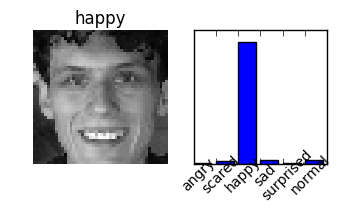

In [98]:
import PIL
from IPython.display import clear_output

clear_output()
plt.rcParams['figure.figsize'] = (1.0, 1.0) # set default size of plots
#plot = plt.imshow(strange_im[0])
cntr = 0;

#faces, marked_img = ut.get_faces_from_img('diff_emotions.jpg');
#faces, marked_img = ut.get_faces_from_img('big_bang.png');
faces, marked_img = ut.get_faces_from_img('camera');

# if some face was found in the image
if(len(faces)):      
    #creating the blank test vector
    data_orig = np.zeros([n_train, 48,48])

    #putting face data into the vector (only first few)
    for i in range(0, len(faces)):
        data_orig[i,:,:] = ut.contrast_stretch(faces[i,:,:]);

        #preparing image and putting it into the batch 
        
        n = data_orig.shape[0];
        data = np.zeros([n,48**2])
        for i in range(n):
            xx = data_orig[i,:,:]
            xx -= np.mean(xx)
            xx /= np.linalg.norm(xx)
            data[i,:] = xx.reshape(2304); #np.reshape(xx,[-1])

    result = sess.run([y], feed_dict={xin: data, keep_prob_input: 1.0})
    
    plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
    for i in range(0, len(faces)):
        emotion_nr = np.argmax(result[0][i]);
        plt_idx = (2*i)+1;
        plt.subplot( 5, 5, plt_idx)
        plt.imshow(np.reshape(data[i,:], (48,48)))
        plt.axis('off')
        plt.title(str_emotions[emotion_nr])
        ax = plt.subplot(5,5, plt_idx +1)
        ax.bar(np.arange(nc) , result[0][i])
        ax.set_xticklabels(str_emotions, rotation=45, rotation_mode="anchor")
        ax.set_yticks([])
        plt.show()
    

# Conclusions and comments
- The data contains a lot of noisy data, i.e. faces are rotated and of different size. 
- A lot of emotions in the dataset were labeled wrong. (e.g. happy images in sad images).
- (we think) That is why we couldn't achieve very good accuracy.
- The accuracy is very good for "Happy" and "Surprised" class. These images seems to be the most "clean" as data. 
- The computational power to train CNN is very high, therefore it was very time consuming to try different computational graphs.
- The facial emotion recognition is has very complicated features that were hard to explore for our computational graphs.

# Possible improvements in the future
- For sure the CNN would perfom better if the faces were always the same size and aligned to be straight. 
- We could try another, deeper CNN architectures to extract more features.


